In [2]:
import os
import pickle
import pandas as pd 
import numpy as np 
from selenobot.utils import RESULTS_DIR, DATA_DIR, dataframe_to_fasta
from selenobot.kegg import kegg_get_genes_by_ko
import fabapi
import matplotlib.pyplot as plt
import requests
import wget

%load_ext autoreload
%autoreload 2

In [3]:
VAL_DIR = os.path.join(DATA_DIR, 'validation', 'v2')

In [5]:
# Start out by analyzing a "sanity check" KO group: KO8348, the formate dehydrogenases.
# One thing to do would be to download the sequences from KEGG, and look at what the model predicts. 

df = kegg_get_genes_by_ko('K08348')
df.set_index('gene_id').to_csv(os.path.join(VAL_DIR, 'K08348.csv'))
df = pd.read_csv(os.path.join(VAL_DIR, 'K08348.csv'))
dataframe_to_fasta(df.rename(columns={'aa_seq':'seq'}).drop(columns=['nt_seq']), os.path.join(VAL_DIR, 'K08348.fasta'))


kegg_get_genes_by_ko: Retrieving genes from KEGG...: 100%|██████████| 603/603 [07:02<00:00,  1.43it/s]


In [4]:
# What fraction of the fdnG proteins are selenoproteins?
sec_fraction = df.aa_seq.str.contains('U').mean()
print(np.round(sec_fraction, 2) * 100, 'percent of K08348 proteins from KEGG contain selenocysteine.')

23.0 percent of K08348 proteins from KEGG contain selenocysteine.


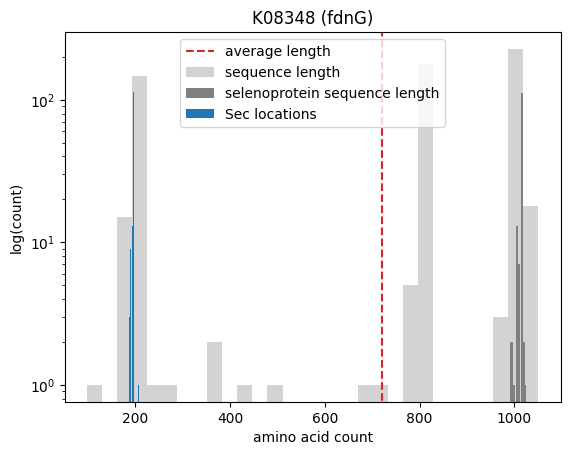

In [28]:
# Where in the sequences do selenoproteins occur?
sec_location = df.aa_seq.str.find('U').values
sec_location = sec_location[sec_location > -1] # Remove cases where U is not found.
average_length = df.aa_seq.apply(len).mean()
lengths = df.aa_seq.apply(len).values
sec_lengths = lengths[df.aa_seq.str.contains('U')]

fig, ax = plt.subplots()
ax.hist(lengths, bins=30, color='lightgray', log=True)
ax.hist(sec_lengths, color='gray', log=True)
ax.hist(sec_location, color='tab:blue', log=True)
ax.vlines(average_length, ymin=0, ymax=ax.get_ylim()[-1], color='tab:red', linestyles='--')
# ax.legend(['Sec locations', 'sequence length', 'average length'])
ax.legend(['average length', 'sequence length', 'selenoprotein sequence length', 'Sec locations'])
ax.set_ylabel('log(count)')
ax.set_xlabel('amino acid count')
ax.set_title('K08348 (fdnG)')
plt.show()

Not really having any luck looking at the MSAs. I wonder if we are going about this the wrong way. Perhaps all, or many, of the results with Kegg annotations are false positives. Because they were successfully annotated, it's likely that they weren't truncated much (or at all). Also, only 10 percent of predicted selenoproteins have annotations! Perhaps it would be more interesting to extend and re-annotate the sequences, and then see if more of them get assigned Kegg ortho groups.

I would also be curious to look in to where selenocysteine tends to appear in the protein sequence (among the known annotations). If it tends to be towards the middle of the sequence, this would support the idea that the successfully-annotated predicted selenoproteins are false positives. In the Kegg ortho groups which do show up, do the selenocysteine residues tend to be towards the terminal end?

It might also be worth plotting the length difference between selenoproteins and non-selenoproteins in some of these Kegg ortho groups, or even computing something like KL divergence between length distributions, and plotting that. Might be worth doing the same thing for the training and test data. 

I also wonder if there is a better way to look at the MSA results than what I am currently doing. Perhaps there is useful information there, I am just having a hard time understanding what's going on. I am confused as to why the length of the alignment string things are greater than the longest sequence being aligned. How does that make sense?